In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from numba import njit

## Integrals

In [2]:
def H_0(p, q):
    """
    The one body part of the hamiltonian
    
    delta = 1
    """
    if p == q:
        p1, s2 = states[p]
        return p1 - 1
    else:
        return 0

In [3]:
def V(p, q, r, s, g):
    """
    The two body part of the hamiltonian
    
    <pq|V|rs>
    """
    # particle 1
    p1, p_s = states[p]
    r1, r_s = states[r]
    # particle 2
    q2, q_s = states[q]
    s2, s_s = states[s]

    if p1 != r1 or q2 != s2: #if particle 1 or 2 isn't in a single energy level
        return 0
    if p_s == r_s or q_s == s_s: #if particle 1 or particle 2 don't have a spin up/down pair
        return 0
    if p_s == q_s and r_s == s_s: #if the particle 1 and particle 2 spin functions match in spins (+- and +-, or -+ and -+)
        return -g/2
    if p_s == s_s and q_s == r_s: #if the particle 1 and particle 2 spin functions don't match in spins (+- and -+, or -+ and +-)
        return g/2

In [143]:
def get_integrals(g):
    h = np.zeros((l, l))
    u = np.zeros((l, l, l, l))

    for p in range(l):
        for q in range(l):
            h[p, q] = H_0(p, q)

            for r in range(l):
                for s in range(l):
                    u[p, q, r, s] = V(p, q, r, s, g) - V(p, q, s, r, g)
                    
    return h, u

In [144]:
l = 8
n = 4

#        [(1, 1), (1, -1), (2, 1), (2, -1), (3, 1), (3, -1), (4, 1), (4, -1)]
states = [(p//2 + 1, 1 if p%2==0 else -1) for p in range(l)]

g_arr = np.linspace(-1, 1, 100)

## Exact solution

In [6]:
def full_CI(g):
    H = np.matrix([ [ 2-g, -g/2, -g/2, -g/2, -g/2,    0],
                    [-g/2,  4-g, -g/2, -g/2,    0, -g/2],
                    [-g/2, -g/2,  6-g,    0, -g/2, -g/2],
                    [-g/2, -g/2,    0,  6-g, -g/2, -g/2],
                    [-g/2,    0, -g/2, -g/2,  8-g, -g/2],
                    [   0, -g/2, -g/2, -g/2, -g/2, 10-g] ])
    vals, vecs = np.linalg.eig(H)
    return np.real(min(vals)) - (2 - g)

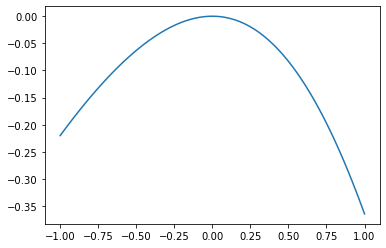

In [7]:
E = [full_CI(g) for g in g_arr]
plt.plot(g_arr, E)
plt.show()

## Hartree-Fock

In [8]:
@njit
def getP(C, n):
    l = C.shape[0]
    P = np.zeros((l, l), dtype="c16")
    
    for a in range(l):
        for b in range(l):
            for i in range(n):
                P[b, a] += np.conj(C[a, i]) * C[b, i]
    return P

@njit
def getF(C, h, u, n):
    l = C.shape[0]
    F = np.zeros((l, l), dtype="c16")
    P = getP(C, n)
    
    F += h
    for a in range(l):
        for b in range(l):
            for c in range(l):
                for d in range(l):
                    F[a, b] += P[d, c] * (u[a, c, b, d] - u[a, c, d, b])
    return F

In [9]:
def SCF(C, h, u, iters):
    for i in range(iters):
        F = getF(C, h, u, n)
        _, C = np.linalg.eigh(F)
    return C

In [72]:
C_initial = np.eye(l, dtype="c16")

In [134]:
C_initial = np.random.rand(l, l)

In [135]:
g = 1
h, u = get_integrals(g)

In [136]:
C = C_initial

In [140]:
C = SCF(C, h, u, 100)

In [141]:
np.round(np.real(C), 2)

array([[ 1.  ,  0.  , -0.  ,  0.  , -0.  ,  0.  , -0.  , -0.  ],
       [ 0.  , -1.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.  ],
       [-0.  ,  0.  ,  0.63,  0.78, -0.  , -0.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.78,  0.63,  0.  , -0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.97, -0.25,  0.  , -0.  ],
       [-0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.97, -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  , -0.03],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.03,  1.  ]])

In [142]:
expected_energy(C)

(1.0000000000000004+0j)

In [14]:
def expected_energy(C):
    P = getP(C, n)
    
    energy = 0.0
    for a in range(l):
        for b in range(l):
            energy += P[b, a] * h[a, b]
            for c in range(l):
                for d in range(l):
                    energy += 0.5 * P[b, a] * P[d, c] * u[a, b, c, d]

    return energy

## Excitation bullshit

In [16]:
perms = {}

for i in itertools.permutations(range(1, l+1)):
    perm = i[:4]
    perml = list(perm)
    if sorted(perml) == perml: #no duplicates
        if perm[0]%2 == 1 and perm[2]%2 == 1: #first and third particle spin up
            if perm[0] == perm[1] - 1 and perm[2] == perm[3] - 1: #only unbroken pairs
                perms[perm] = perm

In [17]:
for i in perms:
    print(i)

(1, 2, 3, 4)
(1, 2, 5, 6)
(1, 2, 7, 8)
(3, 4, 5, 6)
(3, 4, 7, 8)
(5, 6, 7, 8)


In [18]:
perms = [(1, 2, 3, 4),
        (1, 2, 5, 6),
        (1, 2, 7, 8),
        (5, 6, 3, 4),
        (7, 8, 3, 4),
        (5, 6, 7, 8)]

In [ ]:
determinants = []
for perm in perms:
    C = np.zeros((l, l))
    for i, j in zip(range(n), perm):
        C[j - 1, i] = 1
    determinants.append(C)

In [ ]:
for C in determinants:
    print(expected_energy(C))

In [ ]:
def expected_energy_overlap(C1, C2):
    energy = 0.0
    
    for a in range(l):
        for b in range(l):
            for c in range(l):
                for d in range(l):
                    energy += C1[a, 0] * C1[b, 1] * C1[c, 2] * C1[d, 3] * C2[a, 0] * C2[b, 1] * C2[c, 2] * C2[d, 3] * h[a, b]
    
    #for i in range(n):
    #    for j in range(n):
    #        for a in range(l):
    #            for b in range(l):
    #                for c in range(l):
    #                    for d in range(l):
    #                        energy += 0.5 * np.conj(C1[a, i]) * np.conj(C1[b, j]) * C2[c, i] * C2[d, j] * (u[a, b, c, d]-u[a, b, d, c])
    return energy

In [ ]:
%%time

n_dets = len(determinants)
H = np.zeros((n_dets, n_dets))

for i in range(n_dets):
    for j in range(i, n_dets):
        C1, C2 = determinants[i], determinants[j]
        E = expected_energy_overlap(C1, C2)
        H[i, j] = E
        H[j, i] = E

print(H)